可能な限り、Mathematicaの実装に近づけて実装<br>

# Import

In [1]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from IPython.display import display

# 座標変換

In [2]:
def w2c(tMatF, deltF, p1sF): # 世界座標系からカメラ座標系への変換
    p1scnvF = [np.dot(npl.inv(tMatF), p1sF[i] - deltF) for i in range(len(p1sF))]
    return np.stack(p1scnvF)

def c2w(tMatF, deltF, p1sF): # カメラ座標系から世界座標系への変換
    p1scnvF = [np.dot(tMatF, p1sF[[i]]) + deltF for i in range(len(p1sF))]
    return np.stack(p1scnvF)

# パラメータ

In [48]:
zvect = np.array((
    (0.25, 0., 1.),
    (-0.25, 0., 1.),
))

yvect = np.array((
    (0., 1., 0.),
    (0., 1., 0.),
))

# ローカル座標系のワールド座標系での原点座標
delt = np.array((
    (0., 0., 0.),
    (1., 0., 0.),
))

ncamera = len(zvect) # カメラ台数

# 変換行列

In [4]:
# initialize
xvecte, yvecte, zvecte = [np.zeros((ncamera,3)) for i in range(3)]
tM = np.zeros((ncamera,3,3))

for ncm in range(ncamera):
    zvecte[ncm] = zvect[ncm] / npl.norm(zvect[ncm]) # normalize
    yvecte[ncm] = yvect[ncm] / npl.norm(yvect[ncm]) # normalize
    
    if ncm==0:
        xvect = np.array([0., 0., -1])
    elif ncm==1:
        xvect = np.array([0., 0., 1])
    
    xvect[0] = np.roots([zvect[ncm][0], np.dot(xvect[1:], zvect[ncm][1:])]) # ≒ Solve
    xvecte[ncm] = xvect / npl.norm(xvect) # normalize
    
#      # 外積を用いて実装
#     xvect = np.cross(yvecte[ncm], zvecte[ncm])
#     xvecte[ncm] = xvect / npl.norm(xvect) # normalize # yvecteとzvecteが直交している単位ベクトルなので，normalizeは必要ない
    print("xvect:", xvect)
    print("xvecte:", xvecte[ncm])
    
    for i in range(3):
        tM[ncm] = np.transpose(np.stack([xvecte[ncm], yvecte[ncm], zvecte[ncm]]))
    print()
print("tM:\n",tM)

# print("\ntMが直行行列であることを確認")
# print("\n逆行列:\n",npl.inv(tM))
# print("\n転置行列:\n",np.transpose(tM, (0,2,1)))

xvect: [ 4.  0. -1.]
xvecte: [ 0.9701425   0.         -0.24253563]

xvect: [4. 0. 1.]
xvecte: [0.9701425  0.         0.24253563]

tM:
 [[[ 0.9701425   0.          0.24253563]
  [ 0.          1.          0.        ]
  [-0.24253563  0.          0.9701425 ]]

 [[ 0.9701425   0.         -0.24253563]
  [ 0.          1.          0.        ]
  [ 0.24253563  0.          0.9701425 ]]]


# Visualization

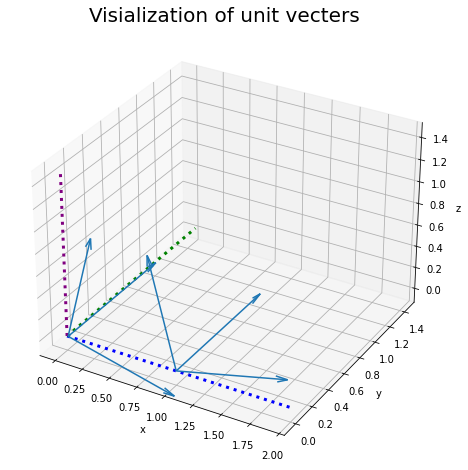

In [5]:
%matplotlib inline
# %matplotlib notebook
fig = plt.figure(figsize=(8, 8)) # 図の設定
ax = fig.add_subplot(projection='3d') # 3Dプロットの設定

for ncm in range(ncamera):
    for vecte in [xvecte, yvecte, zvecte]:
        start = delt[ncm]
        end = vecte[ncm]
        ax.quiver(*start, *end, arrow_length_ratio=0.1) # 矢印プロット

plt.plot([0, 2],[0, 0], [0, 0],
         color='blue', linestyle=':', linewidth=3) # x軸
plt.plot([0, 0],[0, 1.5], [0, 0],
         color='green', linestyle=':', linewidth=3) # y軸
plt.plot([0, 0],[0, 0], [0, 1.5],
         color='purple', linestyle=':', linewidth=3) # z軸

ax.set_xlabel('x') # x軸ラベル
ax.set_ylabel('y') # y軸ラベル
ax.set_zlabel('z') # z軸ラベル
ax.set_title('Visialization of unit vecters', fontsize=20) # タイトル
# ax.legend() # 凡例
ax.set_xlim(-0.1, 2) # x軸の表示範囲
ax.set_ylim(-0.1, 1.5) # y軸の表示範囲
ax.set_zlim(-0.1, 1.5) # z軸の表示範囲
plt.show()

# 

参考：
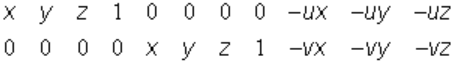

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[ 4.73416264e+04  1.79427487e-10 -1.14791747e+04 -8.78571101e+02
  -3.18308260e-13  5.10420406e+04  1.57194438e-10 -4.17891496e-10
   3.44307595e+00 -7.95388061e-14  1.32632083e+01]
 [ 1.38586110e+04  1.40381613e-11  3.46398809e+03 -1.38553630e+04
   2.89461411e-11  1.49327495e+04  6.46645714e-12 -8.69669961e-12
  -9.99600247e-01  1.43529286e-13  4.00003695e+00]]

dltp2:
 [[ 4.73416262e+04  2.49939659e-11 -1.14791747e+04 -8.78571063e+02
  -3.30032754e-13  5.10420404e+04 -9.03511551e-11  2.25283912e-10
   3.44307593e+00 -1.40657056e-14  1.32632082e+01]
 [ 1.38586110e+04 -2.13433768e-11  3.46398809e+03 -1.38553630e+04
   4.00361969e-13  1.49327495e+04 -3.62282686e-11  9.56922821e-11
  -9.99600247e-01  3.01065005e-14  4.00003695e+00]]

Difference:
 [[ 2.25155338e-04  1.54433521e-10 -4.46456979e

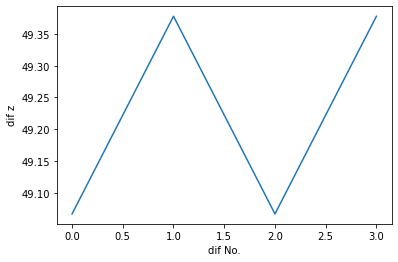


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[ 6.35081460e+04 -8.74165403e-10 -1.55711134e+04 -7.43014197e+02
  -4.16189549e-10  6.84353557e+04 -2.96497779e-10  1.07762227e-09
   4.56551115e+00 -1.57299087e-12  1.79230401e+01]
 [ 1.38967946e+04  1.16775443e-11  3.47329088e+03 -1.38936651e+04
  -5.62844888e-12  1.49770482e+04 -1.36104756e-12 -5.91669075e-13
  -1.00246660e+00 -2.12677098e-15  4.01311878e+00]]

dltp2:
 [[ 6.35081458e+04  3.02553411e-11 -1.55711133e+04 -7.43014208e+02
   6.03229081e-14  6.84353555e+04 -9.95357220e-11  2.48071531e-10
   4.56551114e+00 -1.52133772e-14  1.79230401e+01]
 [ 1.38967946e+04 -1.11838681e-11  3.47329088e+03 -1.38936651e+04
  -5.76282309e-13  1.49770482e+04 -3.16245845e-11  8.17705137e-11
  -1.00246660e+00  1.38662402e-14  4.01311878e+00]]

Di

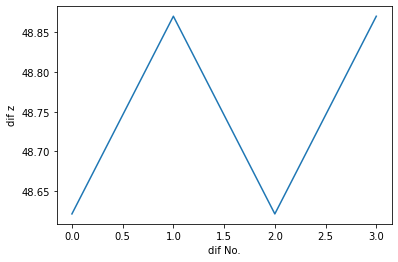


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[ 7.47858515e+04  5.78676081e-10 -1.84393464e+04 -6.21488434e+02
   2.47577887e-11  8.05705857e+04  1.28620669e-11  2.06929335e-11
   5.33548068e+00 -6.39205485e-13  2.11786246e+01]
 [ 1.38183159e+04  6.23218638e-11  3.45426210e+03 -1.38166372e+04
   1.33216400e-11  1.48922956e+04  9.09503260e-11 -2.41327208e-10
  -9.92857976e-01 -4.29777741e-14  3.98781326e+00]]

dltp2:
 [[ 7.47858514e+04  1.51286025e-12 -1.84393464e+04 -6.21488418e+02
   1.33912209e-12  8.05705856e+04 -6.75552744e-11  1.74681970e-10
   5.33548067e+00  3.72452483e-14  2.11786246e+01]
 [ 1.38183159e+04 -1.13456634e-11  3.45426210e+03 -1.38166372e+04
  -7.55219107e-13  1.48922956e+04 -3.18100012e-11  8.25176466e-11
  -9.92857976e-01  1.51476646e-14  3.98781326e+00]]

Di

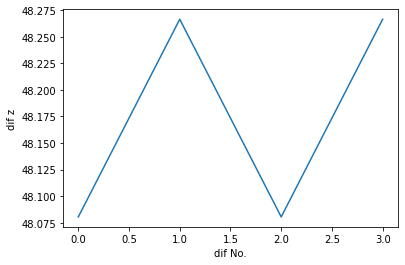


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[ 6.44943399e+04  1.38838610e-09 -1.59179991e+04 -4.96628510e+02
  -3.13535313e-11  6.94624044e+04  7.80464669e-12 -2.04415304e-11
   4.54385254e+00  2.19727882e-13  1.82115087e+01]
 [ 1.39013977e+04 -9.21451053e-11  3.47468636e+03 -1.38987981e+04
  -8.21486721e-12  1.49833186e+04 -1.23456757e-12  1.84575445e-12
  -9.99831300e-01 -2.88831459e-15  4.01468070e+00]]

dltp2:
 [[ 6.44943426e+04  3.37329196e-11 -1.59179997e+04 -4.96628511e+02
  -1.63555472e-11  6.94624071e+04 -9.03749386e-11  2.31755545e-10
   4.54385272e+00 -1.10851870e-14  1.82115094e+01]
 [ 1.39013977e+04 -8.63666683e-12  3.47468636e+03 -1.38987981e+04
  -1.32701796e-12  1.49833186e+04 -3.36072447e-11  8.73058046e-11
  -9.99831300e-01  1.43812855e-14  4.01468070e+00]]

Di

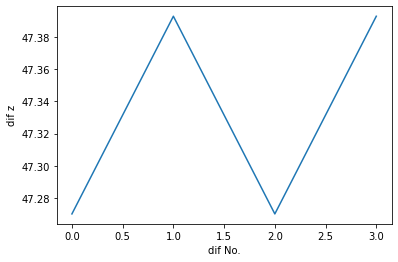


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[ 3.12480925e+04 -2.08980820e-10 -7.66888365e+03 -3.48295833e+02
  -5.10030115e-12  3.36313732e+04 -1.38716729e-13 -3.92488125e-13
   2.10911957e+00  2.29677388e-14  8.62248581e+00]
 [ 1.39251608e+04  2.46510701e-11  3.48001523e+03 -1.39209582e+04
   9.99634403e-15  1.50072244e+04  3.77892162e-14  1.35962075e-12
  -1.00077845e+00  1.34892097e-14  4.02161227e+00]]

dltp2:
 [[ 3.12480924e+04 -8.63533548e-12 -7.66888363e+03 -3.48295832e+02
  -1.90058526e-11  3.36313731e+04 -7.23148306e-11  1.96832134e-10
   2.10911957e+00  4.33797134e-14  8.62248578e+00]
 [ 1.39251608e+04 -9.91269141e-12  3.48001523e+03 -1.39209582e+04
  -4.35009049e-12  1.50072244e+04 -3.53857066e-11  9.25545742e-11
  -1.00077845e+00  9.78576512e-15  4.02161227e+00]]

Di

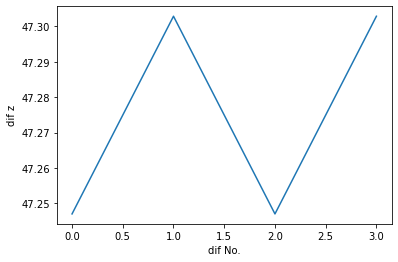


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[-5.55180429e+03 -1.94547347e-11  1.46941077e+03 -2.03292766e+02
   3.45255226e-12 -6.01069214e+03  4.26025968e-12 -1.14844887e-11
  -5.70147354e-01  1.02514351e-13 -1.98653335e+00]
 [ 1.38584530e+04  1.58803231e-11  3.46303644e+03 -1.38537373e+04
   1.07926719e-11  1.49360850e+04  3.93457836e-13 -4.89775928e-12
  -9.99222944e-01 -8.70553629e-14  4.00110284e+00]]

dltp2:
 [[-5.55180430e+03  8.04885292e-13  1.46941078e+03 -2.03292767e+02
   3.00108763e-12 -6.01069214e+03  1.11866730e-11 -3.07407657e-11
  -5.70147354e-01 -6.96265178e-15 -1.98653335e+00]
 [ 1.38584530e+04 -8.49050643e-12  3.46303644e+03 -1.38537373e+04
  -4.55774970e-12  1.49360850e+04 -3.18192721e-11  8.46173954e-11
  -9.99222944e-01  1.44435506e-14  4.00110284e+00]]

Di

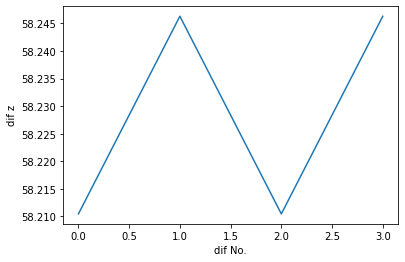


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[-5.55180429e+03 -1.94547347e-11  1.46941077e+03 -2.03292766e+02
   3.45255226e-12 -6.01069214e+03  4.26025968e-12 -1.14844887e-11
  -5.70147354e-01  1.02514351e-13 -1.98653335e+00]
 [ 1.38584530e+04  1.58803231e-11  3.46303644e+03 -1.38537373e+04
   1.07926719e-11  1.49360850e+04  3.93457836e-13 -4.89775928e-12
  -9.99222944e-01 -8.70553629e-14  4.00110284e+00]]

dltp2:
 [[-5.55180430e+03  8.04885292e-13  1.46941078e+03 -2.03292767e+02
   3.00108763e-12 -6.01069214e+03  1.11866730e-11 -3.07407657e-11
  -5.70147354e-01 -6.96265178e-15 -1.98653335e+00]
 [ 1.38584530e+04 -8.49050643e-12  3.46303644e+03 -1.38537373e+04
  -4.55774970e-12  1.49360850e+04 -3.18192721e-11  8.46173954e-11
  -9.99222944e-01  1.44435506e-14  4.00110284e+00]]

Di

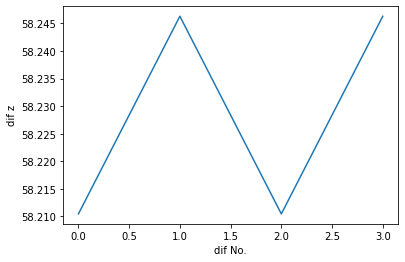


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[-5.55180429e+03 -1.94547347e-11  1.46941077e+03 -2.03292766e+02
   3.45255226e-12 -6.01069214e+03  4.26025968e-12 -1.14844887e-11
  -5.70147354e-01  1.02514351e-13 -1.98653335e+00]
 [ 1.38584530e+04  1.58803231e-11  3.46303644e+03 -1.38537373e+04
   1.07926719e-11  1.49360850e+04  3.93457836e-13 -4.89775928e-12
  -9.99222944e-01 -8.70553629e-14  4.00110284e+00]]

dltp2:
 [[-5.55180430e+03  8.04885292e-13  1.46941078e+03 -2.03292767e+02
   3.00108763e-12 -6.01069214e+03  1.11866730e-11 -3.07407657e-11
  -5.70147354e-01 -6.96265178e-15 -1.98653335e+00]
 [ 1.38584530e+04 -8.49050643e-12  3.46303644e+03 -1.38537373e+04
  -4.55774970e-12  1.49360850e+04 -3.18192721e-11  8.46173954e-11
  -9.99222944e-01  1.44435506e-14  4.00110284e+00]]

Di

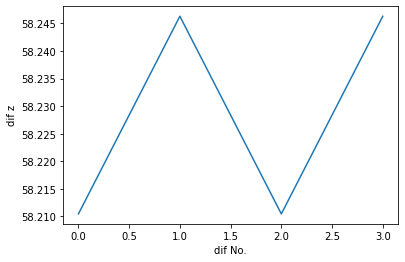


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[-5.55180429e+03  2.61656105e-12  1.46941077e+03 -2.03292766e+02
   3.05836086e-14 -6.01069214e+03 -1.17846705e-13  5.59352911e-13
  -5.70147354e-01  2.23866065e-15 -1.98653335e+00]
 [ 1.38584530e+04  1.03585890e-11  3.46303644e+03 -1.38537373e+04
   5.66986800e-12  1.49360850e+04 -4.21378557e-12  7.86672810e-12
  -9.99222944e-01  3.97043509e-14  4.00110284e+00]]

dltp2:
 [[-5.55180430e+03  8.04885292e-13  1.46941078e+03 -2.03292767e+02
   3.00108763e-12 -6.01069214e+03  1.11866730e-11 -3.07407657e-11
  -5.70147354e-01 -6.96265178e-15 -1.98653335e+00]
 [ 1.38584530e+04 -8.49050643e-12  3.46303644e+03 -1.38537373e+04
  -4.55774970e-12  1.49360850e+04 -3.18192721e-11  8.46173954e-11
  -9.99222944e-01  1.44435506e-14  4.00110284e+00]]

Di

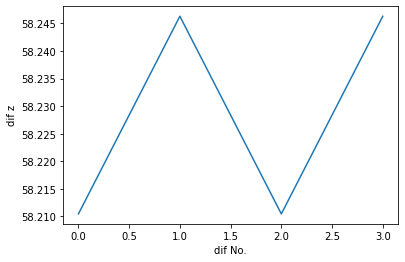


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[-5.55180429e+03  2.61656105e-12  1.46941077e+03 -2.03292766e+02
   3.05836086e-14 -6.01069214e+03 -1.17846705e-13  5.59352911e-13
  -5.70147354e-01  2.23866065e-15 -1.98653335e+00]
 [ 1.38584530e+04  1.03585890e-11  3.46303644e+03 -1.38537373e+04
   5.66986800e-12  1.49360850e+04 -4.21378557e-12  7.86672810e-12
  -9.99222944e-01  3.97043509e-14  4.00110284e+00]]

dltp2:
 [[-5.55180430e+03  8.04885292e-13  1.46941078e+03 -2.03292767e+02
   3.00108763e-12 -6.01069214e+03  1.11866730e-11 -3.07407657e-11
  -5.70147354e-01 -6.96265178e-15 -1.98653335e+00]
 [ 1.38584530e+04 -8.49050643e-12  3.46303644e+03 -1.38537373e+04
  -4.55774970e-12  1.49360850e+04 -3.18192721e-11  8.46173954e-11
  -9.99222944e-01  1.44435506e-14  4.00110284e+00]]

Di

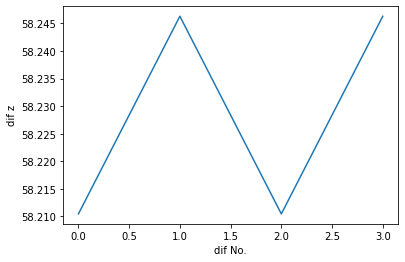


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[-5.55180429e+03  2.61656105e-12  1.46941077e+03 -2.03292766e+02
   3.05836086e-14 -6.01069214e+03 -1.17846705e-13  5.59352911e-13
  -5.70147354e-01  2.23866065e-15 -1.98653335e+00]
 [ 1.38584530e+04  1.03585890e-11  3.46303644e+03 -1.38537373e+04
   5.66986800e-12  1.49360850e+04 -4.21378557e-12  7.86672810e-12
  -9.99222944e-01  3.97043509e-14  4.00110284e+00]]

dltp2:
 [[-5.55180430e+03  8.04885292e-13  1.46941078e+03 -2.03292767e+02
   3.00108763e-12 -6.01069214e+03  1.11866730e-11 -3.07407657e-11
  -5.70147354e-01 -6.96265178e-15 -1.98653335e+00]
 [ 1.38584530e+04 -8.49050643e-12  3.46303644e+03 -1.38537373e+04
  -4.55774970e-12  1.49360850e+04 -3.18192721e-11  8.46173954e-11
  -9.99222944e-01  1.44435506e-14  4.00110284e+00]]

Di

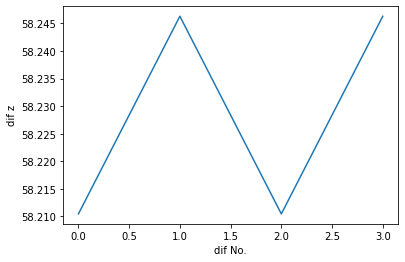


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[-5.55180429e+03  2.61656105e-12  1.46941077e+03 -2.03292766e+02
   3.05836086e-14 -6.01069214e+03 -1.17846705e-13  5.59352911e-13
  -5.70147354e-01  2.23866065e-15 -1.98653335e+00]
 [ 1.38584530e+04  1.03585890e-11  3.46303644e+03 -1.38537373e+04
   5.66986800e-12  1.49360850e+04 -4.21378557e-12  7.86672810e-12
  -9.99222944e-01  3.97043509e-14  4.00110284e+00]]

dltp2:
 [[-5.55180430e+03  8.04885292e-13  1.46941078e+03 -2.03292767e+02
   3.00108763e-12 -6.01069214e+03  1.11866730e-11 -3.07407657e-11
  -5.70147354e-01 -6.96265178e-15 -1.98653335e+00]
 [ 1.38584530e+04 -8.49050643e-12  3.46303644e+03 -1.38537373e+04
  -4.55774970e-12  1.49360850e+04 -3.18192721e-11  8.46173954e-11
  -9.99222944e-01  1.44435506e-14  4.00110284e+00]]

Di

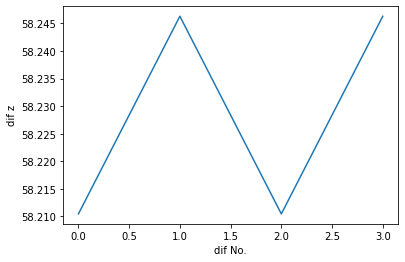


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[-1.66011939e+04 -1.13936733e-11  4.17568454e+03 -6.89989489e+01
  -1.25152005e-13 -1.78942559e+04  3.24537706e-13 -2.96637714e-13
  -1.38438657e+00  1.83499049e-14 -5.15858420e+00]
 [ 1.38148259e+04  2.25609939e-11  3.45122838e+03 -1.38083540e+04
  -2.74136941e-13  1.48875240e+04 -1.89017682e-12 -3.61349492e-12
  -9.95143263e-01 -7.45497414e-14  3.98661348e+00]]

dltp2:
 [[-1.66011938e+04  1.10562271e-14  4.17568453e+03 -6.89989488e+01
   1.03429991e-11 -1.78942559e+04  4.09868069e-11 -1.13492449e-10
  -1.38438656e+00 -2.63513250e-14 -5.15858418e+00]
 [ 1.38148259e+04 -7.95020642e-12  3.45122838e+03 -1.38083540e+04
  -5.51932325e-12  1.48875240e+04 -2.93448005e-11  7.84446476e-11
  -9.95143263e-01  8.10387315e-15  3.98661348e+00]]

Di

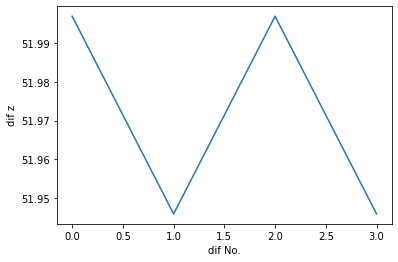


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[-9.96310122e+03 -1.04972237e-12  2.46478758e+03  5.75712303e+01
   5.30760332e-14 -1.07117964e+04  5.52729520e-14 -8.40012088e-13
  -9.25065097e-01  2.84772206e-14 -3.22054301e+00]
 [ 1.37646615e+04  5.85939283e-11  3.43784430e+03 -1.37556848e+04
   5.68364811e-12  1.48352407e+04 -9.75668331e-13  1.16849447e-11
  -9.92700330e-01  7.65915109e-14  3.97144150e+00]]

dltp2:
 [[-9.96310122e+03 -1.86565810e-12  2.46478758e+03  5.75712307e+01
   1.09281805e-11 -1.07117964e+04  2.32712819e-11 -6.81486197e-11
  -9.25065097e-01 -1.17043314e-14 -3.22054301e+00]
 [ 1.37646615e+04 -1.11572822e-11  3.43784430e+03 -1.37556848e+04
  -5.45463360e-12  1.48352407e+04 -2.79305923e-11  7.38852260e-11
  -9.92700330e-01 -1.80447944e-15  3.97144150e+00]]

Di

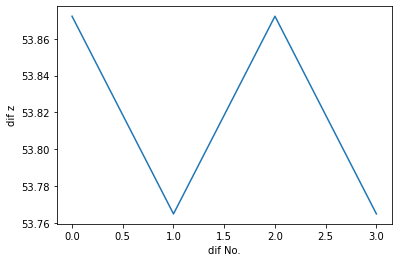


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[ 3.03836872e+04 -9.40889372e-11 -7.66877905e+03  1.77498791e+02
  -2.14055661e-13  3.28045860e+04  2.46421893e-12 -1.70056885e-11
   1.96492191e+00 -5.02358571e-14  8.45296245e+00]
 [ 1.37225556e+04  1.19159101e-10  3.42796470e+03 -1.37146867e+04
  -4.96323013e-12  1.47916728e+04  4.69481225e-13 -2.34326621e-12
  -9.91970650e-01 -1.10043918e-13  3.95917452e+00]]

dltp2:
 [[ 3.03836872e+04  1.48657747e-11 -7.66877904e+03  1.77498789e+02
  -1.40874299e-11  3.28045860e+04 -5.21137901e-11  1.45685705e-10
   1.96492190e+00  2.57930386e-14  8.45296244e+00]
 [ 1.37225556e+04 -2.71070018e-11  3.42796470e+03 -1.37146867e+04
  -4.94259546e-12  1.47916728e+04 -1.85835103e-11  4.55487017e-11
  -9.91970650e-01 -3.42181420e-14  3.95917452e+00]]

Di

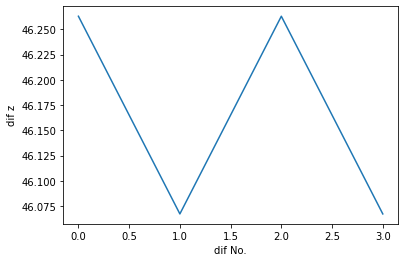


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[-2.27833787e+04  3.03875813e-10  5.57427134e+03  3.15340637e+02
  -1.06587817e-11 -2.44597360e+04 -1.34790681e-12 -1.73175536e-12
  -1.87094611e+00 -7.85899124e-14 -6.87673636e+00]
 [ 1.37233511e+04 -1.49159339e-11  3.42920967e+03 -1.37178622e+04
   7.97613641e-12  1.47929742e+04 -1.49263132e-12  3.93317236e-12
  -9.93237036e-01  8.99141872e-14  3.95994828e+00]]

dltp2:
 [[-2.27833787e+04 -1.66525677e-11  5.57427133e+03  3.15340634e+02
   1.58182168e-11 -2.44597359e+04  4.75805935e-11 -1.37716377e-10
  -1.87094611e+00 -2.68003475e-14 -6.87673634e+00]
 [ 1.37233511e+04 -1.80214923e-11  3.42920967e+03 -1.37178622e+04
  -2.95548320e-12  1.47929742e+04 -1.64678804e-11  4.13127064e-11
  -9.93237036e-01 -1.85014949e-14  3.95994828e+00]]

Di

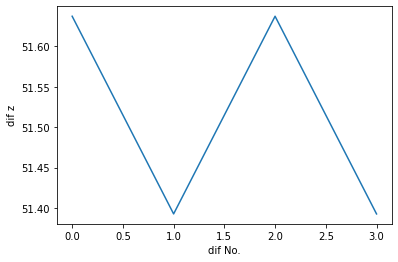


------------------------------------------------------

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

Dimensions:
aMat.shape
 (484, 11) 
bMat.shape
 (484,)

dltp:
 [[-8.84430233e+03  8.20114601e-11  2.04774842e+03  4.39177505e+02
   1.14665680e-12 -9.39896682e+03 -1.94016320e-12  7.40278672e-12
  -8.71407613e-01  4.50455645e-14 -2.82908548e+00]
 [ 1.37314983e+04 -4.83882838e-11  3.43170211e+03 -1.37270483e+04
   6.93848191e-14  1.48015918e+04 -1.73641548e-12  4.63703034e-12
  -9.95031791e-01  5.13061815e-14  3.96316781e+00]]

dltp2:
 [[-8.84430231e+03 -3.08277386e-12  2.04774842e+03  4.39177515e+02
   7.12528400e-12 -9.39896680e+03  2.06141320e-11 -5.93588227e-11
  -8.71407612e-01 -1.67916802e-15 -2.82908547e+00]
 [ 1.37314983e+04 -5.39806977e-12  3.43170211e+03 -1.37270483e+04
  -2.26509587e-12  1.48015918e+04 -2.13168369e-11  5.56136849e-11
  -9.95031791e-01 -1.63319520e-15  3.96316781e+00]]

Di

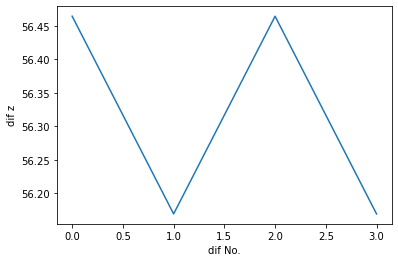


------------------------------------------------------



In [147]:
# 条件を変えてターゲットのイメージを作る

def tgposxy_(xrange, yrange):
    # mathematicaの実装に近づけるため，関数を作成
    # min, max, freq = range の気持ち
    ls = lambda r : np.linspace(r[0], r[1], int((r[1]-r[0])/r[2]+1))
    return np.array([(x, y) for y in ls(yrange) for x in ls(xrange)])

with open("cases.dat") as f:
    cases = f.readlines()
    cases = np.array([case.split('\n')[0].split('\t') for case in cases]).astype(np.float16)

lencases = len(cases)
difmemo = [None for i in range(lencases)]

for nc in range(lencases):

    tgposzFront = cases[nc, 6] # こいつが正確には2.1ではないのでは？
    tgposzRear = cases[nc, 7] # こいつも同様に怪しい
    tgposxy = tgposxy_(cases[nc,0:3], cases[nc,3:6])

    tgpos = np.stack([[tgposxy.T[0], tgposxy.T[1], np.repeat(tgpz, len(tgposxy))] for tgpz in [tgposzFront, tgposzRear]]).transpose(0,2,1) # 個数は同じにすること
    tgpos = np.round(tgpos, 1) # 本当はやっちゃいけない処理だが，浮動小数点の処理が望んだ通りではないので，仕方なく0.1で丸めることにする
    nplain = len(tgpos) # 平面数
    
    foculL = 0.1 # カメラ1の焦点距離
    rez = (4000, 3000) # 画素数
    fov = np.radians([60, 45]) # 画角
    pixelRez = (2*foculL*np.tan(fov/2))/rez # 画素分解能 スクリーン面での

    print("pixelRez = ", pixelRez)
    print("Screen[m] ", (2*foculL*np.tan(fov/2)))

    # initialize
    tgCxy = np.zeros((ncamera, nplain, len(tgpos[0]), 2))
    tgCuv = np.zeros((ncamera, nplain, len(tgpos[0]), 2))
    dltp, dltp2 = [np.zeros((ncamera,11)) for i in range(2)]
    gg = [None for i in range(ncamera)]

    for ncm in range(ncamera):
        # npはnumpyで使われていたため、変数名をnpsに変更
        for nps in range(nplain): # 2平面なので
            # カメラ座標系へ
            cnvw2c = w2c(tM[ncm], delt[ncm], tgpos[nps])

            # カメライメージ
            for j in range(len(cnvw2c)):
                k = (foculL - 0) / (cnvw2c[j, 2] - 0)
                tgCxy[ncm,nps,j] = cnvw2c[j,:2] * k # (x,y)
                tgCuv[ncm,nps,j] = np.round(tgCxy[ncm,nps,j]/pixelRez) # (u,v)

            if ncm==1 or ncm==0:
                fig, ax = plt.subplots()
                ax.scatter(*tgCuv[ncm, 0].T)
                ax.scatter(*tgCuv[ncm, 1].T)
                ax.set_xlim(-rez[0]/2, rez[0]/2)
                ax.set_ylim(-rez[1]/2, rez[1]/2)
                gg[ncm] = (fig, ax)
                plt.close()

        # 可視化パートはよくわからなかったので、いったん保留する

        # DLT 11パラメータを求める
        tg = np.concatenate(tgpos) # flattenにレベルを指定できないため、concatenateかreshapeで対応
    #     print(tg)
        ntgp = len(tg)
        uv = np.concatenate(tgCuv[ncm])
        aMat = np.zeros((ntgp*2,11))
        bMat = np.zeros((ntgp*2,))

        for n in range(ntgp):
            x, y, z, u, v = tg[n,0], tg[n,1], tg[n,2], uv[n,0], uv[n,1]
            aMat[2*n]   = [x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z]
            aMat[2*n+1] = [0, 0, 0, 0, x, y, z, 1, -v*x, -v*y, -v*z]
            bMat[2*n]   = u
            bMat[2*n+1] = v

        print("\nDimensions:\naMat.shape\n", aMat.shape, "\nbMat.shape\n", bMat.shape)
    #     np.set_printoptions(suppress=True)
    #     print("\naMat:\n",aMat)
    #     print("\nbMat:\n",bMat)
        dltp[ncm] = np.dot(npl.pinv(aMat), bMat)
        dltp2[ncm] = np.dot(npl.inv(np.dot(aMat.T, aMat)), np.dot(aMat.T, bMat))

        uvmemo = uv

    print("\ndltp:\n",dltp)
    print("\ndltp2:\n", dltp2)
    print("\nDifference:\n", dltp-dltp2)
    print("\nMax of Difference:\n", np.max(dltp-dltp2))

    # DLT 11パラメータを使った計測
    # 対応点探索誤差を調べる。CPの周囲に、面状に

    aMat = np.zeros((4,3))
    bMat = np.zeros((4,))
    tguv = [1, np.round(tgCuv.shape[2]/2*1).astype(np.uint8)] # ■目標とするCP■ # 前面or後面 CPの番号

    uvori = tgCuv[0:2,tguv[0],tguv[1]] # CPの一つを計測する
    uvori = np.round(np.mean(tgCuv[0:2, 0, :, 0:2], axis=1)) # CPの平均値を計測する　この場合には (x, y) の真値が無い　zはわかる

    duv = np.array([[[k1,k2] for k1 in [0, 1]] for k2 in [0, 1]]).astype(np.float16) # CPの周囲に変化させる

    # 面状の範囲 単位はpixel # 0すなわちその場所と，1画素ずれた位置

    nt1end = 1; nt2end = 1
    nt1end = duv.shape[0]; nt2end = duv.shape[1]
    memotgp3D = np.array([[[0, [0,0,0]] for i in range(nt1end)] for j in range(nt2end)],dtype=object)
    dif = np.zeros((nt1end, nt2end,3))

    print("tguv No. =", tguv, "\ntg=\n", tgCuv[[0,1],tguv[0], tguv[1]], "  [pixel]")
    print("tgpos[tguv[0],tguv[1]] =", tgpos[tguv[0], tguv[1]])
    print("tgposzFront =", tgposzFront)
    print("tgposzRear =", tgposzRear)

    # 可視化パートは未完成
    # ggp1 = plt.subplots()
    # ggp1[1].scatter(*tgCuv[0, tguv[0], tguv[1]], s=50, c='red')
    # ggp2 = plt.subplots()
    # ggp2[1].scatter(*tgCuv[1, tguv[0], tguv[1]], s=50, c='red')
    # plt.close()

    for nt2 in range(nt2end):
        for nt1 in range(nt1end):
            uv = uvori + duv[nt1, nt2]

            for n in range(ncamera):
                aMat[2*n]   = uv[n,0]*dltp[n,8:11]-dltp[n,0:3]
                aMat[2*n+1] = uv[n,1]*dltp[n,8:11]-dltp[n,4:7]
                bMat[2*n]   = dltp[n,3] - uv[n,0]
                bMat[2*n+1] = dltp[n,7] - uv[n,1]

            print('\nnt1: {}, nt2: {}'.format(nt1,nt2))
            print('aMat:\n',aMat)
            tgp3D = np.dot(np.dot(npl.inv(np.dot(aMat.T, aMat)),aMat.T), bMat)
            memotgp3D[nt1, nt2] = tgp3D, tgpos[tguv[0], tguv[1]]
#             dif[nt1, nt2] = (tgp3D - np.array([0,0,tgposzFront]))*1000 # 差をミリで
            dif[nt1, nt2] = (tgp3D - np.array([0,0,2.1]))*1000 # 本当はダメ

    difmemo[nc] = dif

    lp = plt.subplots()
    lp[1].plot(np.concatenate(dif)[:,2])
    lp[1].set_xlabel('dif No.')
    lp[1].set_ylabel('dif z')
    display(lp[0])
    plt.close()
    
    print('\n------------------------------------------------------\n')
difmemo = np.stack(difmemo)

(0.0, 100.0)

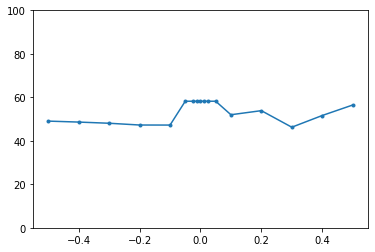

In [151]:
difp = plt.subplots()
difp[1].plot(cases[:,0], difmemo[:,0,0,2], marker='.')
difp[1].set_ylim(0,100)

In [139]:
tgp3D

array([1.01291970e+00, 5.93952458e-04, 2.15616884e+00])

In [140]:
dif

array([[[1.01233721e+03, 8.75469357e-14, 5.64645590e+01],
        [1.01291970e+03, 8.75582287e-14, 5.61688534e+01]],

       [[1.01233720e+03, 5.94046847e-01, 5.64645422e+01],
        [1.01291970e+03, 5.93952458e-01, 5.61688365e+01]]])

In [131]:
tgp3D[2] - 2.1

0.05616883654037075

In [136]:
tgp3D[2] - tgposzFront

0.05655946154037084

In [133]:
tgposzFront

2.1

In [128]:
(tgp3D - np.array([0,0,tgposzFront]))[2]

0.05655946154037084

In [135]:
np.array([tgposzFront])

array([2.1], dtype=float16)

In [142]:
duv

array([[[0., 0.],
        [1., 0.]],

       [[0., 1.],
        [1., 1.]]], dtype=float16)